In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error
from ensembles.random_forest import RandomForestMSE
from ensembles.boosting import GradientBoostingMSE
from ensembles.utils import rmsle
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

**ЭКСПЕРИМЕНТЫ**

In [2]:
df = pd.read_csv('kc_house_data.csv')

In [3]:
df.shape

(21613, 21)

In [120]:
df['price'].mean()

540088.1417665294

In [121]:
df['price'].std()

367127.19648269983

In [4]:
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [5]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [7]:
df.nunique()

id               21436
date               372
price             4028
bedrooms            13
bathrooms           30
sqft_living       1038
sqft_lot          9782
floors               6
waterfront           2
view                 5
condition            5
grade               12
sqft_above         946
sqft_basement      306
yr_built           116
yr_renovated        70
zipcode             70
lat               5034
long               752
sqft_living15      777
sqft_lot15        8689
dtype: int64

In [8]:
df['zipcode']

0        98178
1        98125
2        98028
3        98136
4        98074
         ...  
21608    98103
21609    98146
21610    98144
21611    98027
21612    98144
Name: zipcode, Length: 21613, dtype: int64

In [9]:
df['price'].corr(df['zipcode'])

-0.0532028542983257

In [119]:
df['price'].corr(df['yr_renovated'])

0.12643379344089303

id, date, zipcode не будем включать в число признаков для обучения.

In [10]:
X = df.drop(columns=["price", "zipcode", "id", "date"])

In [11]:
y = df['price']

In [12]:
X.nunique()

bedrooms           13
bathrooms          30
sqft_living      1038
sqft_lot         9782
floors              6
waterfront          2
view                5
condition           5
grade              12
sqft_above        946
sqft_basement     306
yr_built          116
yr_renovated       70
lat              5034
long              752
sqft_living15     777
sqft_lot15       8689
dtype: int64

In [13]:
categorical = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

In [14]:
encoder = OneHotEncoder(sparse_output=False)
X_cat_new = encoder.fit_transform(X[categorical])

In [15]:
X = pd.concat([X.drop(columns=categorical), pd.DataFrame(X_cat_new)], axis=1)

In [16]:
X

,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,...,63,64,65,66,67,68,69,70,71,72
0,1180,5650,1180,0,1955,0,47.5112,-122.257,1340,5650,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2570,7242,2170,400,1951,1991,47.7210,-122.319,1690,7639,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,770,10000,770,0,1933,0,47.7379,-122.233,2720,8062,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1960,5000,1050,910,1965,0,47.5208,-122.393,1360,5000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1680,8080,1680,0,1987,0,47.6168,-122.045,1800,7503,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,1530,1131,1530,0,2009,0,47.6993,-122.346,1530,1509,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
21609,2310,5813,2310,0,2014,0,47.5107,-122.362,1830,7200,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
21610,1020,1350,1020,0,2009,0,47.5944,-122.299,1020,2007,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
21611,1600,2388,1600,0,2004,0,47.5345,-122.069,1410,1287,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

**Эксперимент 2**

In [44]:
max_depth_vals = np.linspace(3, 20, num=9).astype(int)
max_features_vals = np.linspace(0.1, 1, num=10)

errors = []
history_data = []

In [45]:
for max_depth in max_depth_vals:
    for max_features in max_features_vals:
        model = RandomForestMSE(n_estimators=100, tree_params={'max_depth': max_depth, 'max_features': max_features})
        history = model.fit(X=X_train, y=y_train, X_val=X_test, y_val=y_test, trace=True, patience=3)
        errors.append({'max_depth': max_depth, 'max_features': max_features, 'rmse': history['val'][-1], 'time': history['time'][-1]})
        history_data.append({'max_depth': max_depth, 'max_features': max_features, 'history': history})
        print(f"On params max_depth={max_depth}, max_features={max_features: .01f}: RMSE={errors[-1]['rmse']}, time={history_data[-1]['history']['time'][-1]}")

On params max_depth=3, max_features= 0.1: RMSE=267104.67594154616, time=0.31765294075012207
On params max_depth=3, max_features= 0.2: RMSE=255130.26193580497, time=0.2691359519958496
On params max_depth=3, max_features= 0.3: RMSE=250200.48406995495, time=0.7770133018493652
On params max_depth=3, max_features= 0.4: RMSE=227277.55596340465, time=1.1494636535644531
On params max_depth=3, max_features= 0.5: RMSE=228392.0488237594, time=0.36609339714050293
On params max_depth=3, max_features= 0.6: RMSE=229202.34617505127, time=0.8211691379547119
On params max_depth=3, max_features= 0.7: RMSE=223893.08572582598, time=0.42963075637817383
On params max_depth=3, max_features= 0.8: RMSE=226394.5235219856, time=0.5161135196685791
On params max_depth=3, max_features= 0.9: RMSE=227226.1653738228, time=1.415562391281128
On params max_depth=3, max_features= 1.0: RMSE=230878.8062330314, time=1.9695568084716797
On params max_depth=5, max_features= 0.1: RMSE=236467.58882625867, time=2.260143518447876
On

In [46]:
res_err = pd.DataFrame(errors)

In [47]:
res_err[res_err['rmse'] == res_err['rmse'].min()]

,max_depth,max_features,rmse,time
74,17,0.5,138058.552999,3.193114


In [60]:
import matplotlib.pyplot as plt

In [61]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

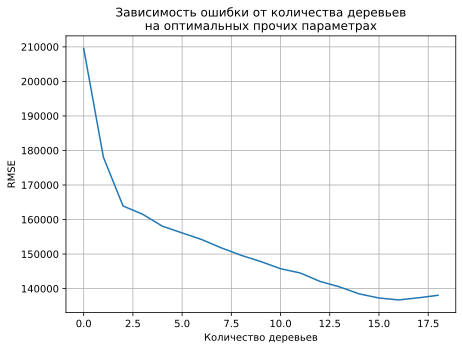

In [62]:
_, ax = plt.subplots(figsize=(7, 5))
ax.plot(range(len(history_data[74]['history']['val'])), history_data[74]['history']['val'])
ax.set_xlabel('Количество деревьев')
ax.set_ylabel('RMSE')
ax.set_title('Зависимость ошибки от количества деревьев\nна оптимальных прочих параметрах')
ax.grid()
plt.savefig("1.pdf", format="pdf")
plt.show()

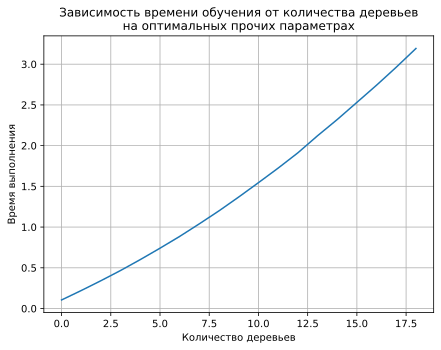

In [63]:
_, ax = plt.subplots(figsize=(7, 5))
ax.plot(range(len(history_data[74]['history']['time'])), history_data[74]['history']['time'])
ax.set_xlabel('Количество деревьев')
ax.set_ylabel('Время выполнения')
ax.set_title('Зависимость времени обучения от количества деревьев\nна оптимальных прочих параметрах')
ax.grid()
plt.savefig("1_time.pdf", format="pdf")
plt.show()

In [64]:
res_err

,max_depth,max_features,rmse,time
0,3,0.1,267104.675942,0.317653
1,3,0.2,255130.261936,0.269136
2,3,0.3,250200.484070,0.777013
3,3,0.4,227277.555963,1.149464
4,3,0.5,228392.048824,0.366093
...,...,...,...,...
85,20,0.6,141266.277263,3.869163
86,20,0.7,139579.158173,14.875645
87,20,0.8,140860.302486,4.360314
88,20,0.9,142142.803160,5.934909


In [65]:
xy = res_err[abs(res_err['max_features'] - 0.5) < 1e-9]

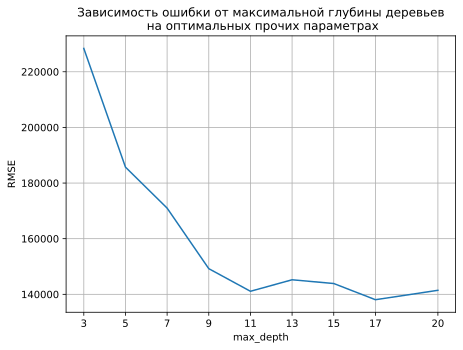

In [66]:
_, ax = plt.subplots(figsize=(7, 5))
ax.plot(xy['max_depth'], xy['rmse'])
ax.set_xlabel('max_depth')
ax.set_ylabel('RMSE')
ax.set_title('Зависимость ошибки от максимальной глубины деревьев\n на оптимальных прочих параметрах')
ax.grid()
ax.set_xticks(xy['max_depth'])
plt.savefig("2.pdf", format="pdf")
plt.show()

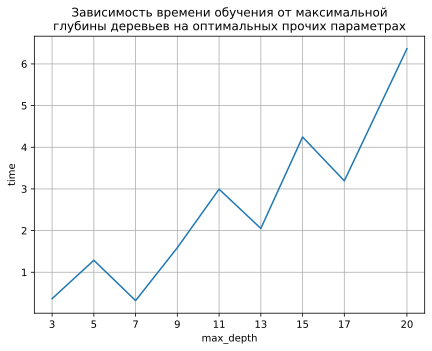

In [67]:
_, ax = plt.subplots(figsize=(7, 5))
ax.plot(xy['max_depth'], xy['time'])
ax.set_xlabel('max_depth')
ax.set_ylabel('time')
ax.set_title('Зависимость времени обучения от максимальной\nглубины деревьев на оптимальных прочих параметрах')
ax.grid()
ax.set_xticks(xy['max_depth'])
plt.savefig("2_time.pdf", format="pdf")
plt.show()

In [68]:
xy = res_err[res_err['max_depth'] == 17]

In [69]:
xy

,max_depth,max_features,rmse,time
70,17,0.1,158656.140001,5.339301
71,17,0.2,152263.308967,1.506148
72,17,0.3,145036.163416,4.020302
73,17,0.4,155733.225367,1.070038
74,17,0.5,138058.552999,3.193114
75,17,0.6,151704.984373,1.365205
76,17,0.7,143243.876208,12.205193
77,17,0.8,152122.764426,2.144922
78,17,0.9,151328.689619,3.660929
79,17,1.0,156155.351741,2.530428


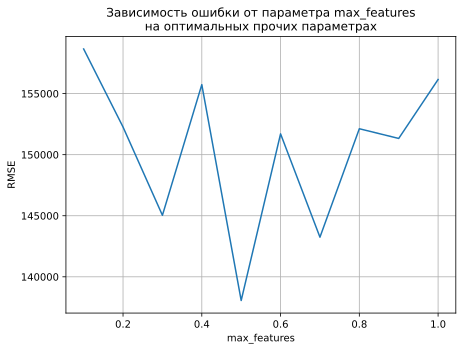

In [72]:
_, ax = plt.subplots(figsize=(7, 5))
ax.plot(xy['max_features'], xy['rmse'])
ax.set_xlabel('max_features')
ax.set_ylabel('RMSE')
ax.set_title('Зависимость ошибки от параметра max_features\nна оптимальных прочих параметрах')
ax.grid()
plt.savefig("3.pdf", format="pdf")
plt.show()

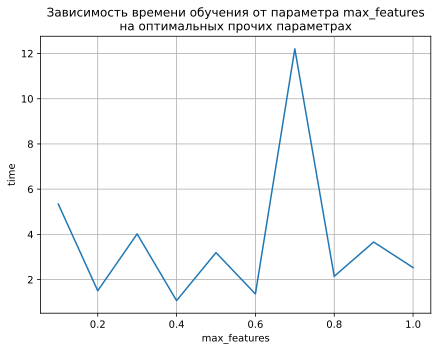

In [73]:
_, ax = plt.subplots(figsize=(7, 5))
ax.plot(xy['max_features'], xy['time'])
ax.set_xlabel('max_features')
ax.set_ylabel('time')
ax.set_title('Зависимость времени обучения от параметра max_features\nна оптимальных прочих параметрах')
ax.grid()
plt.savefig("3_time.pdf", format="pdf")
plt.show()

**Экперимент 3**

In [21]:
max_depth_vals = np.linspace(3, 20, num=9).astype(int)
max_features_vals = np.linspace(0.1, 1, num=10)
learning_rate_vals = np.linspace(0.05, 0.5, num=5)

In [22]:
errors = []
history_data = []
for max_depth in max_depth_vals:
    for max_features in max_features_vals:
        for learning_rate in learning_rate_vals:
            model = GradientBoostingMSE(
                n_estimators=100,
                learning_rate=learning_rate,
                tree_params={'max_depth': max_depth, 'max_features': max_features}
            )
            history = model.fit(X=X_train, y=y_train, X_val=X_test, y_val=y_test, trace=True, patience=3)
            errors.append({'max_depth': max_depth, 'max_features': max_features, 'learning_rate': learning_rate,'rmse': history['val'][-1], 'time': history['time'][-1]})
            history_data.append({'max_depth': max_depth, 'max_features': max_features, 'learning_rate': learning_rate, 'history': history})
            print(f"On params max_depth={max_depth}, max_features={max_features: .01f}:, learning_rate={learning_rate: .02f} RMSE={errors[-1]['rmse']}, time={history_data[-1]['history']['time'][-1]}")

On params max_depth=3, max_features= 0.1:, learning_rate= 0.05 RMSE=174278.539755075, time=5.146394491195679
On params max_depth=3, max_features= 0.1:, learning_rate= 0.16 RMSE=149343.04516782414, time=4.719291925430298
On params max_depth=3, max_features= 0.1:, learning_rate= 0.28 RMSE=151007.9706943217, time=3.551435708999634
On params max_depth=3, max_features= 0.1:, learning_rate= 0.39 RMSE=164916.55035141177, time=1.8511016368865967
On params max_depth=3, max_features= 0.1:, learning_rate= 0.50 RMSE=192291.27963362914, time=0.1371917724609375
On params max_depth=3, max_features= 0.2:, learning_rate= 0.05 RMSE=163041.39827726915, time=5.133763790130615
On params max_depth=3, max_features= 0.2:, learning_rate= 0.16 RMSE=156815.4819823348, time=1.762946367263794
On params max_depth=3, max_features= 0.2:, learning_rate= 0.28 RMSE=163301.48734549625, time=2.7040231227874756
On params max_depth=3, max_features= 0.2:, learning_rate= 0.39 RMSE=155455.8085583824, time=3.202436923980713
On 

In [23]:
res_err = pd.DataFrame(errors)

In [25]:
res_err[res_err['rmse'] == res_err['rmse'].min()]

,max_depth,max_features,learning_rate,rmse,time
160,9,0.3,0.05,123816.714079,8.526444


In [74]:
import pickle

In [75]:
with open("res_err.pkl", "rb") as file:
    res_err = pickle.load(file)

In [76]:
with open("res_hist.pkl", "rb") as file:
    res_hist = pickle.load(file)

In [77]:
res_err = pd.DataFrame(res_err)

In [78]:
res_err[res_err['rmse'] == res_err['rmse'].min()]

,max_depth,max_features,learning_rate,rmse,time
160,9,0.3,0.05,123816.714079,8.526444


In [79]:
from matplotlib.ticker import MaxNLocator

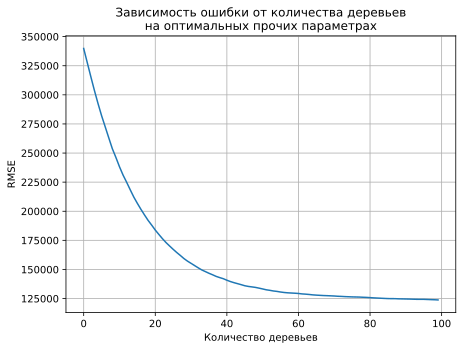

In [80]:
_, ax = plt.subplots(figsize=(7, 5))
ax.plot(range(len(res_hist[160]['history']['val'])), res_hist[160]['history']['val'])
ax.set_xlabel('Количество деревьев')
ax.set_ylabel('RMSE')
ax.set_title('Зависимость ошибки от количества деревьев\nна оптимальных прочих параметрах')
ax.grid()
ax.yaxis.set_major_locator(MaxNLocator(10))
plt.savefig("1_boost.pdf", format="pdf")
plt.show()

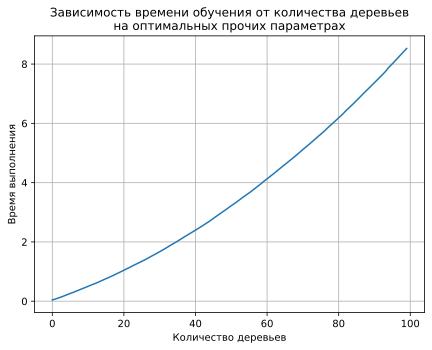

In [81]:
_, ax = plt.subplots(figsize=(7, 5))
ax.plot(range(len(res_hist[160]['history']['time'])), res_hist[160]['history']['time'])
ax.set_xlabel('Количество деревьев')
ax.set_ylabel('Время выполнения')
ax.set_title('Зависимость времени обучения от количества деревьев\nна оптимальных прочих параметрах')
ax.grid()
plt.savefig("1_time_boost.pdf", format="pdf")
plt.show()

In [82]:
xy = res_err[np.logical_and(abs(res_err['max_features'] - 0.3) < 1e-9, abs(res_err['learning_rate'] - 0.05) < 1e-9)]

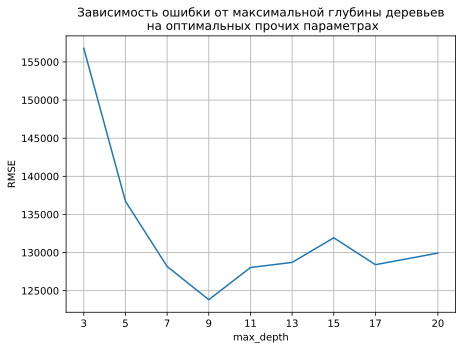

In [83]:
_, ax = plt.subplots(figsize=(7, 5))
ax.plot(xy['max_depth'], xy['rmse'])
ax.set_xlabel('max_depth')
ax.set_ylabel('RMSE')
ax.set_title('Зависимость ошибки от максимальной глубины деревьев\n на оптимальных прочих параметрах')
ax.grid()
ax.set_xticks(xy['max_depth'])
plt.savefig("2_boost.pdf", format="pdf")
plt.show()

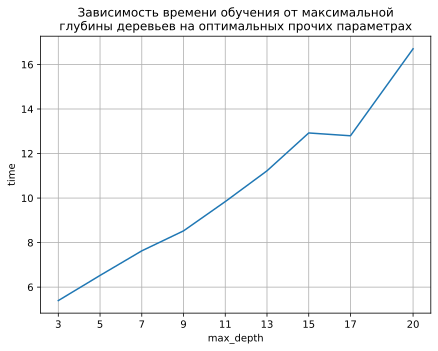

In [84]:
_, ax = plt.subplots(figsize=(7, 5))
ax.plot(xy['max_depth'], xy['time'])
ax.set_xlabel('max_depth')
ax.set_ylabel('time')
ax.set_title('Зависимость времени обучения от максимальной\nглубины деревьев на оптимальных прочих параметрах')
ax.grid()
ax.set_xticks(xy['max_depth'])
plt.savefig("2_time_boost.pdf", format="pdf")
plt.show()

In [85]:
xy = res_err[np.logical_and(res_err['max_depth'] == 9, abs(res_err['learning_rate'] - 0.05) < 1e-9)]

In [86]:
xy

,max_depth,max_features,learning_rate,rmse,time
150,9,0.1,0.05,132591.659676,6.192053
155,9,0.2,0.05,129818.937961,7.403539
160,9,0.3,0.05,123816.714079,8.526444
165,9,0.4,0.05,129054.638365,9.738682
170,9,0.5,0.05,126462.690912,10.800818
175,9,0.6,0.05,127744.886784,11.780060
180,9,0.7,0.05,133655.376885,13.012254
185,9,0.8,0.05,130961.040754,13.924715
190,9,0.9,0.05,137955.065871,15.099469
195,9,1.0,0.05,143456.203089,16.126709


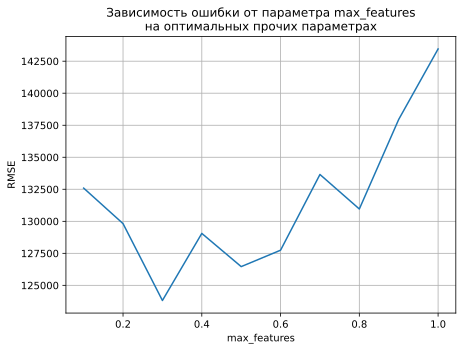

In [87]:
_, ax = plt.subplots(figsize=(7, 5))
ax.plot(xy['max_features'], xy['rmse'])
ax.set_xlabel('max_features')
ax.set_ylabel('RMSE')
ax.set_title('Зависимость ошибки от параметра max_features\nна оптимальных прочих параметрах')
ax.grid()
plt.savefig("3_boost.pdf", format="pdf")
plt.show()

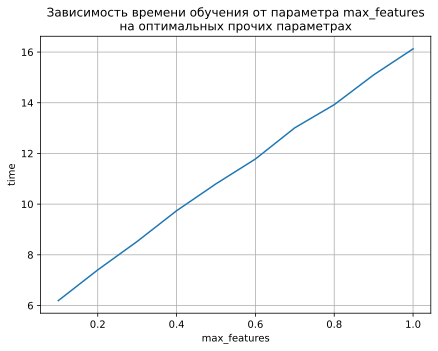

In [88]:
_, ax = plt.subplots(figsize=(7, 5))
ax.plot(xy['max_features'], xy['time'])
ax.set_xlabel('max_features')
ax.set_ylabel('time')
ax.set_title('Зависимость времени обучения от параметра max_features\nна оптимальных прочих параметрах')
ax.grid()
plt.savefig("3_time_boost.pdf", format="pdf")
plt.show()

In [89]:
xy = res_err[np.logical_and(res_err['max_depth'] == 9, abs(res_err['max_features'] - 0.3) < 1e-9)]

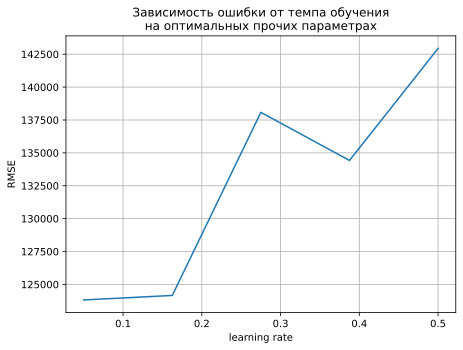

In [92]:
_, ax = plt.subplots(figsize=(7, 5))
ax.plot(xy['learning_rate'], xy['rmse'])
ax.set_xlabel('learning rate')
ax.set_ylabel('RMSE')
ax.set_title('Зависимость ошибки от темпа обучения\nна оптимальных прочих параметрах')
ax.grid()
plt.savefig("4_boost.pdf", format="pdf")
plt.show()

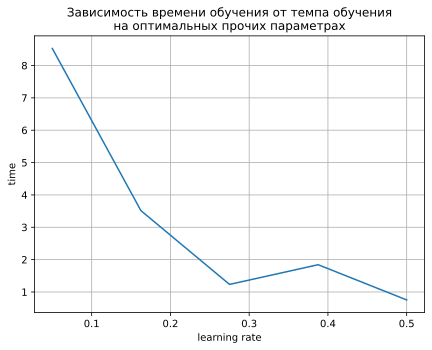

In [93]:
_, ax = plt.subplots(figsize=(7, 5))
ax.plot(xy['learning_rate'], xy['time'])
ax.set_xlabel('learning rate')
ax.set_ylabel('time')
ax.set_title('Зависимость времени обучения от темпа обучения\nна оптимальных прочих параметрах')
ax.grid()
plt.savefig("4_time_boost.pdf", format="pdf")
plt.show()

**Проверка без ограничения глубины деревьев**

Случайный лес

In [122]:
max_features_vals = np.linspace(0.1, 1, num=10)

In [123]:
errors = []
history_data = []

In [124]:
for max_features in max_features_vals:
    model = RandomForestMSE(n_estimators=100, tree_params={'max_features': max_features})
    history = model.fit(X=X_train, y=y_train, X_val=X_test, y_val=y_test, trace=True, patience=3)
    errors.append({'max_features': max_features, 'rmse': history['val'][-1], 'time': history['time'][-1]})
    history_data.append({'max_features': max_features, 'history': history})
    print(f"On params max_features={max_features: .01f}: RMSE={errors[-1]['rmse']}, time={history_data[-1]['history']['time'][-1]}")

On params max_features= 0.1: RMSE=161510.70911548458, time=1.718522548675537
On params max_features= 0.2: RMSE=160314.66987329093, time=0.7482302188873291
On params max_features= 0.3: RMSE=150738.11865736102, time=1.5613129138946533
On params max_features= 0.4: RMSE=146060.98686308562, time=2.4823977947235107
On params max_features= 0.5: RMSE=150528.5252780048, time=1.9086501598358154
On params max_features= 0.6: RMSE=140122.94512733378, time=6.7522218227386475
On params max_features= 0.7: RMSE=150021.2487905096, time=2.0567917823791504
On params max_features= 0.8: RMSE=153904.08102203737, time=2.0355241298675537
On params max_features= 0.9: RMSE=147882.15154315377, time=3.3893802165985107
On params max_features= 1.0: RMSE=156452.7098903424, time=2.077728509902954


In [125]:
res_err = pd.DataFrame(errors)

In [126]:
res_err

,max_features,rmse,time
0,0.1,161510.709115,1.718523
1,0.2,160314.669873,0.748230
2,0.3,150738.118657,1.561313
3,0.4,146060.986863,2.482398
4,0.5,150528.525278,1.908650
5,0.6,140122.945127,6.752222
6,0.7,150021.248791,2.056792
7,0.8,153904.081022,2.035524
8,0.9,147882.151543,3.389380
9,1.0,156452.709890,2.077729


In [111]:
res_err[res_err['rmse'] == res_err['rmse'].min()]

,max_features,rmse,time
5,0.6,137973.30176,4.990759


In [131]:
len(history_data[5]['history']['val'])

27

Градиентный бустинг

In [112]:
max_features_vals = np.linspace(0.1, 1, num=10)
learning_rate_vals = np.linspace(0.05, 0.5, num=5)

In [113]:
errors = []
history_data = []
for max_features in max_features_vals:
    for learning_rate in learning_rate_vals:
        model = GradientBoostingMSE(
            n_estimators=100,
            learning_rate=learning_rate,
            tree_params={'max_features': max_features}
        )
        history = model.fit(X=X_train, y=y_train, X_val=X_test, y_val=y_test, trace=True, patience=3)
        errors.append({'max_features': max_features, 'learning_rate': learning_rate,'rmse': history['val'][-1], 'time': history['time'][-1]})
        history_data.append({'max_features': max_features, 'learning_rate': learning_rate, 'history': history})
        print(f"On params max_features={max_features: .01f}:, learning_rate={learning_rate: .02f} RMSE={errors[-1]['rmse']}, time={history_data[-1]['history']['time'][-1]}")

On params max_features= 0.1:, learning_rate= 0.05 RMSE=156604.28283986505, time=15.092772006988525
On params max_features= 0.1:, learning_rate= 0.16 RMSE=166339.1617480053, time=14.956128358840942
On params max_features= 0.1:, learning_rate= 0.28 RMSE=172769.46653071014, time=11.978484392166138
On params max_features= 0.1:, learning_rate= 0.39 RMSE=179116.35017911458, time=6.724059820175171
On params max_features= 0.1:, learning_rate= 0.50 RMSE=178657.14278894835, time=5.347179174423218
On params max_features= 0.2:, learning_rate= 0.05 RMSE=144142.8243768557, time=18.417128324508667
On params max_features= 0.2:, learning_rate= 0.16 RMSE=147943.40990902018, time=18.407077074050903
On params max_features= 0.2:, learning_rate= 0.28 RMSE=148616.70653384118, time=14.389476537704468
On params max_features= 0.2:, learning_rate= 0.39 RMSE=163240.20950038094, time=7.698624849319458
On params max_features= 0.2:, learning_rate= 0.50 RMSE=167643.80584799603, time=5.0723631381988525
On params max_f

In [114]:
res_err = pd.DataFrame(errors)

In [116]:
res_err[res_err['rmse'] == res_err['rmse'].min()]

,max_features,learning_rate,rmse,time
10,0.3,0.05,137048.011965,20.852978
